# Working with Binance API
- https://python-binance.readthedocs.io/en/latest/overview.html

In [1]:
import datetime as dt
import os
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import dateparser

from binance.client import Client

In [2]:
API_PUBLIC = os.environ.get("B_PUBLIC_KEY")
API_SECRET = os.environ.get("B_SECRET_KEY")
client = Client(API_PUBLIC, API_SECRET)

In [3]:
def get_closes(symbol, interval, timedelta, d1=None):
    if d1 is None:
        d1 = dt.datetime.now(dt.timezone.utc)
    assert d1.tzinfo == dt.timezone.utc, "must use utc timezone dates"
    d0 = d1 - timedelta
    start_str = dt.datetime.strftime(d0, "%d-%m-%Y %H:%M:%S")
    (
        t0, o, h, 
        l, c, v, 
        t1, quote_asset_vol, num_trades, 
        tbb_vol, tbq_vol, _
    ) = zip(
        *client.get_historical_klines(
            symbol=symbol, 
            interval=interval, 
            start_str=start_str
        )
    )
    df = pd.DataFrame(
        data=np.array([t0, o, h, l, c, v, t1, quote_asset_vol, num_trades, tbb_vol, tbq_vol]).T, 
        columns=["t0", "o", "h", "l", "c", "v", "t1", "quote_asset_vol", "num_trades", "tbb_vol", "tbq_vol"]
    )
    
    date_cols = ["t0", "t1"]
    float_cols = ["o", "h", "l", "c", "v", "quote_asset_vol", "tbb_vol", "tbq_vol"]
    int_cols = ["num_trades"]
    df["t0"] = df["t0"].apply(dateparser.parse)
    df["t1"] = df["t1"].apply(dateparser.parse)
    
    df[float_cols] = df[float_cols].astype(float)
    df[int_cols] = df[int_cols].astype(int)
    return df[["t1", "c"]]

def get_log_returns(returns):
    return np.log(returns[1:]/returns[:-1])

In [4]:
ltc_sym = "LTCBTC"
eth_sym = "ETHBTC"
interval = Client.KLINE_INTERVAL_5MINUTE
timedelta = dt.timedelta(days=5)
eth_df = get_closes(eth_sym, interval, timedelta)
ltc_df = get_closes(ltc_sym, interval, timedelta)

eth_lr = get_log_returns(eth_df["c"].values)
ltc_lr = get_log_returns(ltc_df["c"].values)
diff = eth_lr - ltc_lr
hedge_ratio = (eth_df["c"]/ltc_df["c"]).values[1:]

data = np.stack([eth_lr, ltc_lr, diff, hedge_ratio]).T
cols = ["eth", "ltc", "diff", "hedge_ratio"]
ix = eth_df["t1"].values[1:]
df = pd.DataFrame(data=data, columns=cols, index=ix)

In [5]:
plt.style.use("fivethirtyeight")

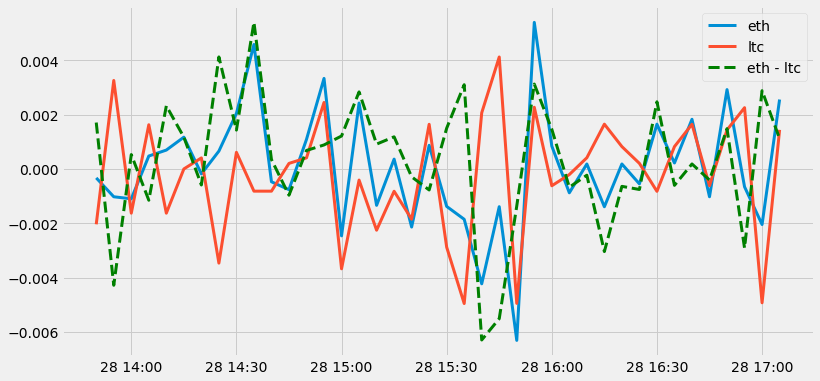

In [6]:
t1 = 10
t2 = 50
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(12,6))
linewidth = 3
alpha = 1
ax1.plot(df.iloc[t1:t2]["eth"],linewidth=linewidth, alpha=alpha, label="eth")
ax1.plot(df.iloc[t1:t2]["ltc"], linewidth=linewidth, alpha=alpha, label="ltc")
ax1.plot(df.iloc[t1:t2]["diff"], "--g", linewidth=linewidth, alpha=alpha, label="eth - ltc")
ax1.legend(loc="best")

# Using Gluon

# Make Dataset

In [56]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

In [57]:
# start with simple 1-dim eth returns
eth_returns = df["eth"]
holdout_size = 60
freq = "5min"

# make basic datasets
start_date = pd.Timestamp(eth_returns.index[0], freq=freq)
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: eth_returns.values[:-holdout_size],
            FieldName.START: start_date
        }
    ],
    freq = freq
)
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: eth_returns.values,
            FieldName.START: start_date
        }
    ],
    freq = freq
)

# train_shapes = [a["target"].shape for a in iter(train_ds)]
# test_shapes = [a["target"].shape for a in iter(test_ds)]
# list(zip(train_shapes, test_shapes))

# make transformations for them (add extra features and split up into examples as well)
context_length = 45
prediction_length = 3

# (45 steps context, 3 predict) 4hr segments, predict the last 15 min
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )
transformation = create_transformation(freq, context_length, prediction_length)
train_tf = transformation(iter(train_ds), is_train=True)
test_tf = transformation(iter(test_ds), is_train=False)


In [50]:
train_tf = transformation(iter(train_ds), is_train=True)

print("For train dataset entry")
train_tf_entry = next(iter(train_tf))
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print()

print("For test dataset entry")
test_tf_entry = next(iter(test_tf))
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")

For train dataset entry
past target shape: (45,)
future target shape: (3,)
past observed values shape: (45,)
future observed values shape: (3,)
past age feature shape: (45, 1)
future age feature shape: (3, 1)

For test dataset entry
past target shape: (45,)
future target shape: (0,)
past observed values shape: (45,)
future observed values shape: (0,)
past age feature shape: (45, 1)
future age feature shape: (3, 1)


# build Estimator

In [59]:
from gluonts.model import deepvar, wavenet, deep_factor
from gluonts.mx.trainer import Trainer